In [1]:
!pip install transformers datasets==3.5.1 torch bitsandbytes accelerate hf_xet --q
!pip install peft trl wandb --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [39]:
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    TrainingArguments,
    EarlyStoppingCallback
)
from datasets import load_dataset
from peft import LoraConfig, get_peft_model, TaskType, prepare_model_for_kbit_training
from trl import SFTTrainer, SFTConfig
import wandb
import json

In [3]:
# Check GPU availability
print(f"GPU: {torch.cuda.get_device_name() if torch.cuda.is_available() else 'None'}")
print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f}GB" if torch.cuda.is_available() else "No GPU")

GPU: Tesla T4
Memory: 15.8GB


In [ ]:
# Login to W&B Account
from google.colab import userdata
WANDB_API_KEY = userdata.get('WANDB_KEY')

wandb.login(key=WANDB_API_KEY)

In [ ]:
# Initialize W&B for tracking
wandb.init(
    project="smollm2-boolq-finetune",
    name="smollm2-boolq-yesno-finetuned",
    config={
        "model": "SmolLM2-1.7B-Instruct",
        "dataset": "BoolQ Training",
        "target_benchmark": "BoolQ Validation",
        "quantization": "4-bit",
        "method": "LoRA"
    }
)

In [4]:
# Same quantization config - 4-bit weights, FP16 compute
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,  # Compute in FP16 for stability
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

PATH_DIR = "/content/drive/MyDrive/coding/projects/LLM Finetuning + Benchmarking"
CACHE_DIR = PATH_DIR+"/hf_cache"

# Load model and tokenizer
model_name = "HuggingFaceTB/SmolLM2-1.7B-Instruct"
print(f"Loading {model_name} for finetuning...")

tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=CACHE_DIR)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=quantization_config,
    device_map="auto",
    torch_dtype=torch.float16,
    cache_dir=CACHE_DIR
)

Loading HuggingFaceTB/SmolLM2-1.7B-Instruct for finetuning...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
# Prepare model for k-bit training
model = prepare_model_for_kbit_training(model)

In [6]:
# LoRA configuration
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj"
    ],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
)

# Add LoRA adapters
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

print(f"Memory after LoRA: {torch.cuda.memory_allocated() / 1e9:.2f}GB")

trainable params: 18,087,936 || all params: 1,729,464,320 || trainable%: 1.0459
Memory after LoRA: 1.31GB


In [ ]:
# Load BoolQ Train dataset
print("Loading BoolQ training dataset...")
train_data  = load_dataset("boolq", split="train", cache_dir=CACHE_DIR)
val_data = load_dataset("boolq", split="validation[1500:2000]", cache_dir=CACHE_DIR)
print(f"Loaded {len(train_data)} train examples") # 9427 train examples
print(f"Loaded {len(val_data)} val examples") # 500 val examples

In [8]:
def format_boolq_example(example):
    """Format BoolQ example for training"""
    passage = example['passage']
    question = example['question']
    answer = "Yes" if example['answer'] else "No"

    # Use same chat format as evaluation
    messages = [
        {
            "role": "user",
            "content": f"Read this passage and answer the question with only 'Yes' or 'No'.\n\nPassage: {passage}\n\nQuestion: {question}"
        },
        {
            "role": "assistant",
            "content": answer
        }
    ]

    text = tokenizer.apply_chat_template(messages, tokenize=False)
    return {"text": text}

In [ ]:
# Filter and process Natural Questions data
print("Processing BoolQ training data...")
train_dataset = train_data.map(
    format_boolq_example,
    remove_columns=train_data.column_names,
    num_proc=4  # Parallel processing
    )

In [ ]:
# Filter and process Natural Questions data
print("Processing BoolQ training data...")
val_dataset  = val_data.map(
    format_boolq_example,
    remove_columns=val_data.column_names,
    num_proc=4  # Parallel processing
    )

In [11]:
print(f"Training examples: {len(train_dataset)}")
print(f"Validation examples: {len(val_dataset)}")

Training examples: 9427
Validation examples: 500


In [27]:
# Show example
print("\n=== TRAINING EXAMPLE ===")
print(train_dataset[0]['text'][:500] + "...", '\n---\n')
print(train_dataset[0]['text'][::-1][:110][::-1])
print("========================\n")


=== TRAINING EXAMPLE ===
<|im_start|>system
You are a helpful AI assistant named SmolLM, trained by Hugging Face<|im_end|>
<|im_start|>user
Read this passage and answer the question with only 'Yes' or 'No'.

Passage: Persian (/ˈpɜːrʒən, -ʃən/), also known by its endonym Farsi (فارسی fārsi (fɒːɾˈsiː) ( listen)), is one of the Western Iranian languages within the Indo-Iranian branch of the Indo-European language family. It is primarily spoken in Iran, Afghanistan (officially known as Dari since 1958), and Tajikistan (offi... 
---

bet.

Question: do iran and afghanistan speak the same language<|im_end|>
<|im_start|>assistant
Yes<|im_end|>




In [40]:
sft_config = SFTConfig(
    output_dir=PATH_DIR+"/finetune_output",
    num_train_epochs=3,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=2e-4,
    warmup_steps=200,
    weight_decay=0.01,

    # Logging and evaluation
    logging_steps=25,                      # Log every 25 steps
    eval_steps=200,                        # Evaluate every 200 steps
    save_steps=400,                        # Save every 400 steps
    eval_strategy="steps",
    save_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,

    # Early stopping patience
    save_total_limit=3,                    # Keep only 3 best checkpoints

    # Performance settings
    fp16=True,
    dataloader_pin_memory=False,
    remove_unused_columns=False,

    # W&B integration
    report_to="wandb",
    run_name="smollm2-boolq-yesno-finetuned",
    logging_first_step=True,

    # SFT-specific parameters
    max_seq_length=512,
    packing=False,
    dataset_text_field="text",
)

# Add early stopping callback
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=3,             # Stop if no improvement for 3 evals
    early_stopping_threshold=0.01          # Minimum improvement threshold
)

In [ ]:
# Initialize trainer with SFTConfig
trainer = SFTTrainer(
    model=model,
    args=sft_config,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    processing_class=tokenizer,
    callbacks=[early_stopping],
)

In [42]:
# Log hyperparameters to W&B
wandb.config.update({
    "train_samples": len(train_dataset),
    "val_samples": len(val_dataset),
    "max_seq_length": 512,
    "lora_r": lora_config.r,
    "lora_alpha": lora_config.lora_alpha,
    "baseline_accuracy": 0.564,  # Our target to beat
})

In [43]:
print(f"Target: Beat 56.4% accuracy on BoolQ")
print(f"W&B tracking: {wandb.run.url}")

Target: Beat 56.4% accuracy on BoolQ
W&B tracking: https://wandb.ai/chinmayajoshi-/smollm2-boolq-finetune/runs/jb8tqo3y


In [ ]:
# Start training
print("Starting finetuning...")
print(f"Training on {len(train_dataset)} BoolQ examples")
trainer.train()

Starting finetuning...
Training on 9427 BoolQ examples


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss
200,1.439700,1.329177
400,1.384900,1.301399
600,1.325400,1.283433
800,1.311700,1.269072
1000,1.250800,1.254278


config.json:   0%|          | 0.00/908 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


**WAND Loss Curve**
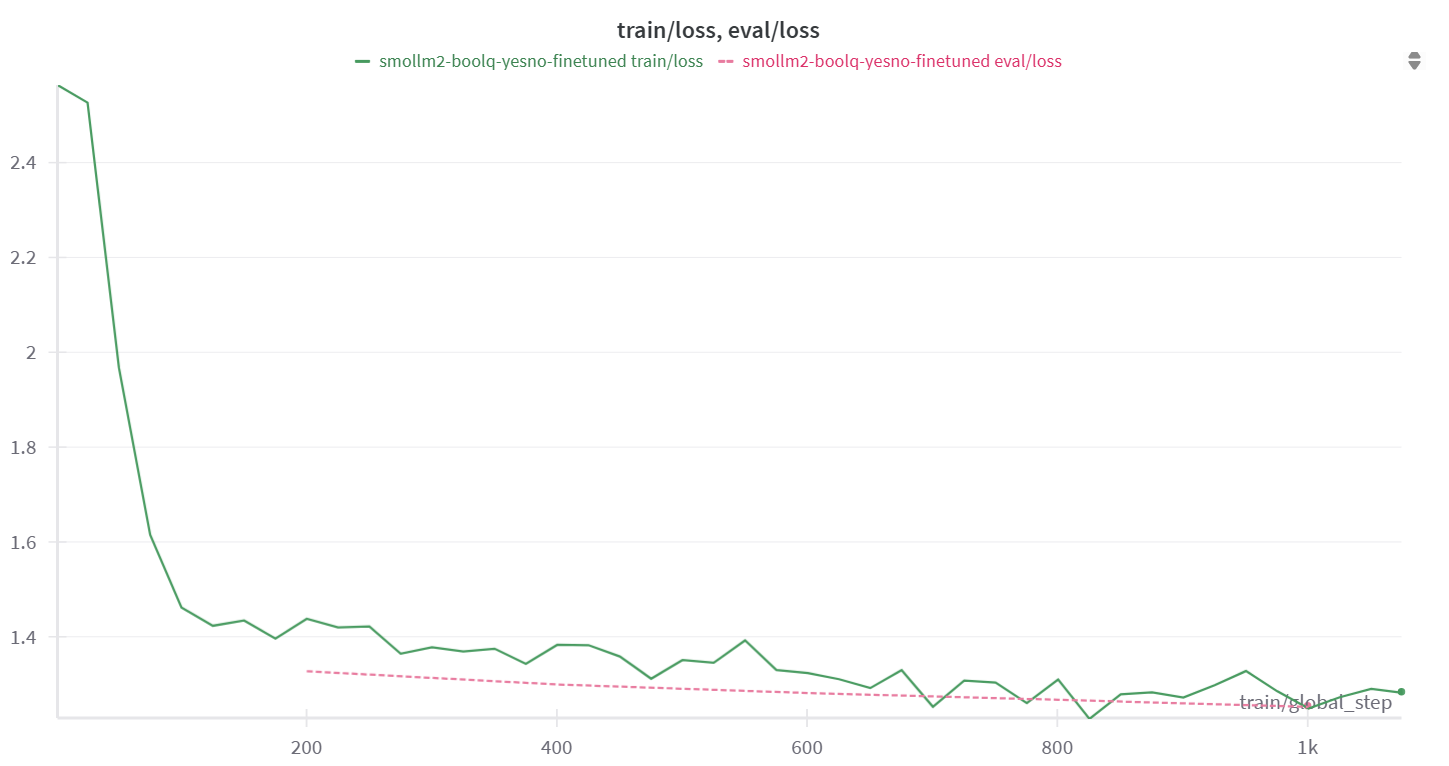

In [ ]:
# Save the finetuned model
print("Saving finetuned model...")
trainer.save_model()
trainer.save_state()

In [ ]:
# Log final metrics
final_metrics = trainer.state.log_history[-1]
wandb.log({"final_train_loss": final_metrics.get("train_loss", 0)})

In [ ]:
print("Finetuning completed!")
print(f"Model saved to: {sft_config.output_dir}")
print(f"W&B run: {wandb.run.url}")

In [ ]:
# Cleanup
wandb.finish()
del trainer
torch.cuda.empty_cache()